# LSTM track finding for variable-sized detector layers in 2D data

In this notebook we explore an LSTM model which can process detector layers of variable size to do hit classification. The model is very similar to the basic LSTM for fixed size detector layers, but uses detector-layer-specific fully-connected layers to transform the data to a fixed-size representation which is fed into the LSTM like before.

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers
from matplotlib import pyplot as plt
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Local imports
from data import (get_mask_ranges, construct_mask,
                  apply_det_mask, expand_masked_data,
                  generate_straight_tracks,
                  generate_track_bkg, generate_uniform_noise)
from drawing import draw_2d_event, draw_2d_input_and_pred
from metrics import calc_hit_accuracy

%matplotlib notebook

Using TensorFlow backend.


## Utilities

In [2]:
def draw_train_history(history, acc_keys, draw_val=False, figsize=(9.5,5)):
    """Make plots of training and validation losses and accuracies"""
    plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'],
                 label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Plot accuracies
    plt.subplot(122)
    for k in acc_keys:
        label = k.replace('_acc', '').replace('_', ' ')
        plt.plot(history.epoch, history.history[k], label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc=0)

## Define the model

In [3]:
def build_model(widths, hidden_size,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    """
    Build a flexible lstm model which handles variable-width inputs.
    
    Inputs and outputs are split by layer. Each input feeds through a unique
    sub-network to transform to a fixed-width space. The resulting sequence is fed
    into the LSTM. The output sequence is split and each output is transformed
    through another sub-network to the target layer's width.
    """
    depth = len(widths)
    inputs = [layers.Input(shape=(w,)) for w in widths]
    # Transform each input to fixed size representation
    hidden = [layers.Dense(hidden_size)(i) for i in inputs]
    # Combine them into a sequence
    hidden = [layers.Reshape((1, hidden_size))(h) for h in hidden]
    hidden = layers.merge(hidden, mode='concat', concat_axis=1)
    # Feed the sequence into an LSTM
    hidden = layers.LSTM(output_dim=hidden_size, return_sequences=True)(hidden)
    # Split the outputs by detector layer
    hidden = [layers.Lambda(lambda x: x[:,i,:])(hidden)
              for i in range(depth)]    
    # Transform outputs to target size
    out_names = ['output_%i' % i for i in range(depth)]
    outputs = [layers.Dense(widths[i], activation='softmax',
                            name=out_names[i])(hidden[i])
               for i in range(depth)]
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

## Define the detector

A detector of 1D layers, masked to have variable size.

In [4]:
# The rectangular full detector shape
det_shape = det_depth, det_width = 48, 48

# Detector mask, arbitrary shape for now
mask_shapes = (np.arange(1, det_depth+1)/1.7 + 1).astype(int)*2
mask_shapes[mask_shapes > det_width] = det_width
det_mask = construct_mask(det_shape, mask_shapes)
mask_ranges = get_mask_ranges(det_shape, mask_shapes)

<IPython.core.display.Javascript object>


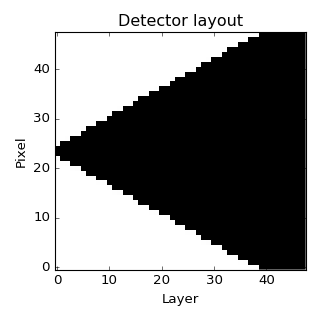

In [5]:
# Visualize the detector layout
plt.figure(figsize=(4,4))
draw_2d_event(det_mask, title='Detector layout', cmap='gray_r')

## Generate the data

Single-track signals, with track and noise backgrounds

In [6]:
# Config defaults
num_bkg_tracks = 5
noise_prob = 0
seed_size = 5

In [7]:
def batch_generator(num_events, det_shape=det_shape,
                    det_mask=det_mask, mask_ranges=mask_ranges,
                    num_bkg_tracks=num_bkg_tracks, noise_prob=noise_prob,
                    seed_size=seed_size, binary=True):
    while True:
        # Generate signal tracks in the masked region
        sig_tracks = generate_straight_tracks(
            num_events, det_shape,
            entry_range=mask_ranges[0],
            exit_range=mask_ranges[-1])
   
        # Generate track background
        bkg_tracks = generate_track_bkg(
            num_events, det_shape,
            tracks_per_event=num_bkg_tracks,
            skip_layers=seed_size)
    
        # Generate noise background
        noise = generate_uniform_noise(
            num_events, det_shape, prob=noise_prob)
    
        # Combine into full events
        events = sig_tracks + bkg_tracks + noise
        if binary:
            events[events > 1] = 1

        # Mask the data
        yield (apply_det_mask(events, det_mask),
               apply_det_mask(sig_tracks, det_mask))

## Train the model

In [8]:
# Config
num_hidden = 48
batch_size = 128
num_epoch = 10
epoch_size = 102400

# Build and train the model
model = build_model(mask_shapes, hidden_size=num_hidden)
history = model.fit_generator(batch_generator(batch_size),
                              samples_per_epoch=epoch_size,
                              nb_epoch=num_epoch)

Epoch 1/10
102400/102400 [==============================] - 131s - loss: 37.0165 - output_0_loss: 0.0503 - output_1_loss: 0.1084 - output_2_loss: 0.1005 - output_3_loss: 0.1350 - output_4_loss: 0.1247 - output_5_loss: 0.2394 - output_6_loss: 0.3081 - output_7_loss: 0.3869 - output_8_loss: 0.4111 - output_9_loss: 0.4626 - output_10_loss: 0.5240 - output_11_loss: 0.5206 - output_12_loss: 0.5265 - output_13_loss: 0.6001 - output_14_loss: 0.6361 - output_15_loss: 0.6602 - output_16_loss: 0.6950 - output_17_loss: 0.7090 - output_18_loss: 0.7471 - output_19_loss: 0.7776 - output_20_loss: 0.7994 - output_21_loss: 0.8296 - output_22_loss: 0.8598 - output_23_loss: 0.8693 - output_24_loss: 0.8816 - output_25_loss: 0.8898 - output_26_loss: 0.8994 - output_27_loss: 0.9104 - output_28_loss: 0.9572 - output_29_loss: 0.9471 - output_30_loss: 0.9770 - output_31_loss: 0.9908 - output_32_loss: 1.0038 - output_33_loss: 1.0133 - output_34_loss: 1.0374 - output_35_loss: 1.0552 - output_36_loss: 1.0618 - ou

<IPython.core.display.Javascript object>


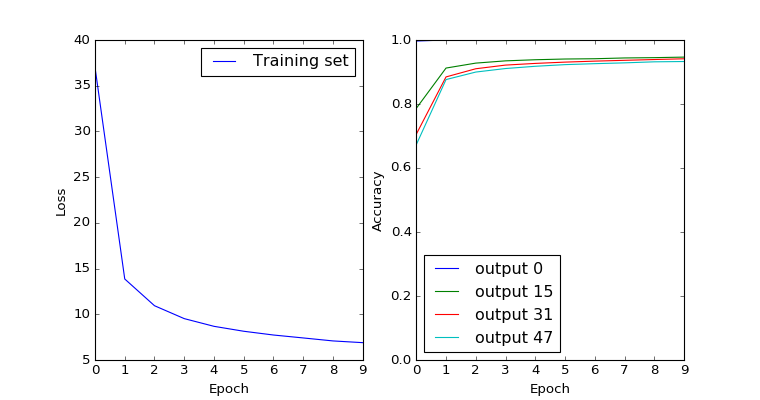

In [9]:
# Plot the training history
accuracy_keys = ['output_0_acc', 'output_15_acc', 'output_31_acc', 'output_47_acc']
draw_train_history(history, acc_keys=accuracy_keys)

## Evalulation

Generate a test set and evaluate the model.

In [10]:
# Generate a test set
num_test = 10240
test_input, test_target = batch_generator(num_test).next()
test_input_fixed = expand_masked_data(test_input, det_mask)
test_target_fixed = expand_masked_data(test_target, det_mask)

In [11]:
# Make predictions and calculate metrics
test_pred = model.predict(test_input)
test_pred_fixed = expand_masked_data(test_pred, det_mask)

evals = model.evaluate(test_input, test_target)
metrics = dict(zip(model.metrics_names, evals))

10208/10240 [============================>.] - ETA: 0s

<IPython.core.display.Javascript object>


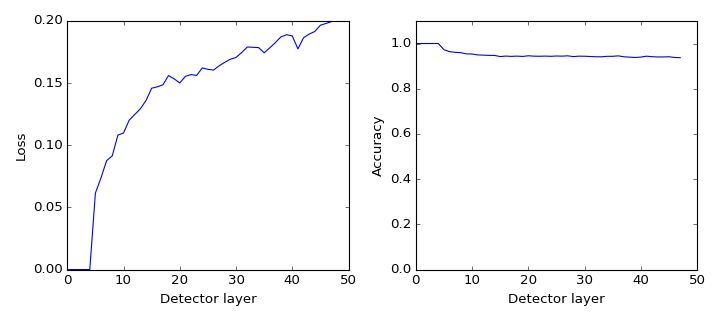

In [12]:
# Plot the loss and accuracy as a function of detector layer
losses = [metrics['output_%i_loss' % i] for i in range(det_depth)]
accuracies = [metrics['output_%i_acc' % i] for i in range(det_depth)]
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(losses)
plt.xlabel('Detector layer')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(accuracies)
plt.xlabel('Detector layer')
plt.ylabel('Accuracy')
plt.ylim((0, 1.1))
plt.tight_layout()

<IPython.core.display.Javascript object>


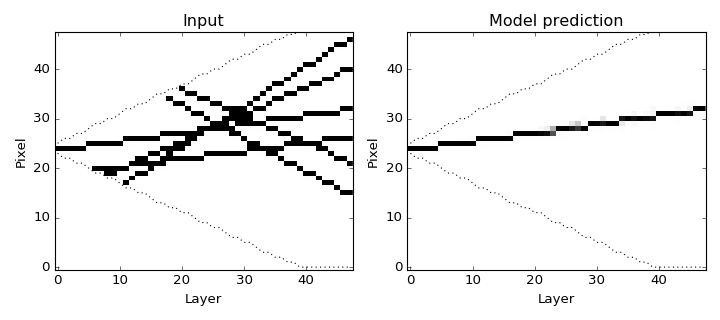

<IPython.core.display.Javascript object>


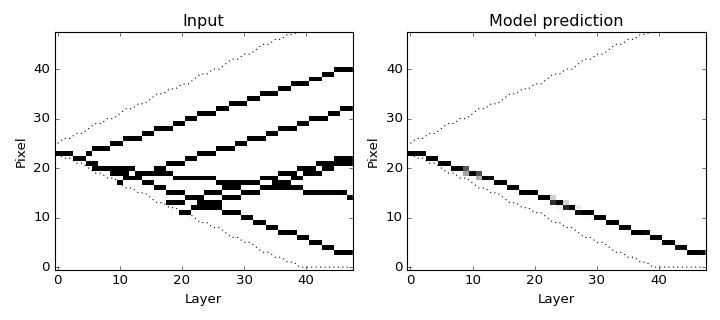

<IPython.core.display.Javascript object>


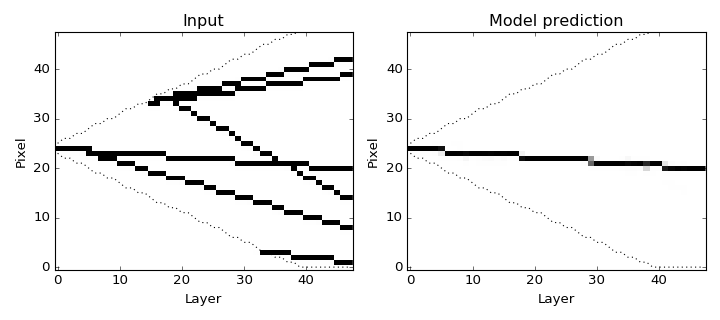

<IPython.core.display.Javascript object>


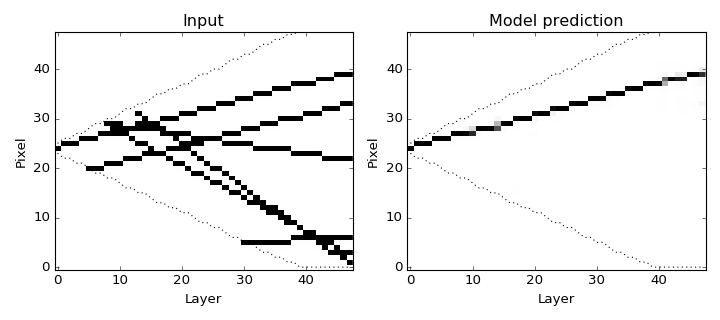

In [16]:
# Visualize some events
i = 0
for i in [23, 24, 25, 26]:
    draw_2d_input_and_pred(test_input_fixed[i], test_pred_fixed[i],
                           mask_ranges=mask_ranges, cmap='gray_r',
                           mask_style='k:');